In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.dates as mdates

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
# 1. 데이터 로드
url = "AAME.csv"
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# 확인용
print("컬럼 목록:", df.columns)
print(df.head())

# 예측 대상 컬럼 ('Close' 기준)
target_column = 'Close'

컬럼 목록: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
            Open  High   Low  Close  Adj Close  Volume
Date                                                  
1980-03-17   0.0  4.05  3.85   3.85   3.213167   15000
1980-03-18   0.0  4.00  3.80   3.80   3.171437   10200
1980-03-19   0.0  4.05  3.85   3.85   3.213167   33500
1980-03-20   0.0  4.00  3.80   3.80   3.171437    8700
1980-03-21   0.0  3.95  3.75   3.75   3.129709   12700


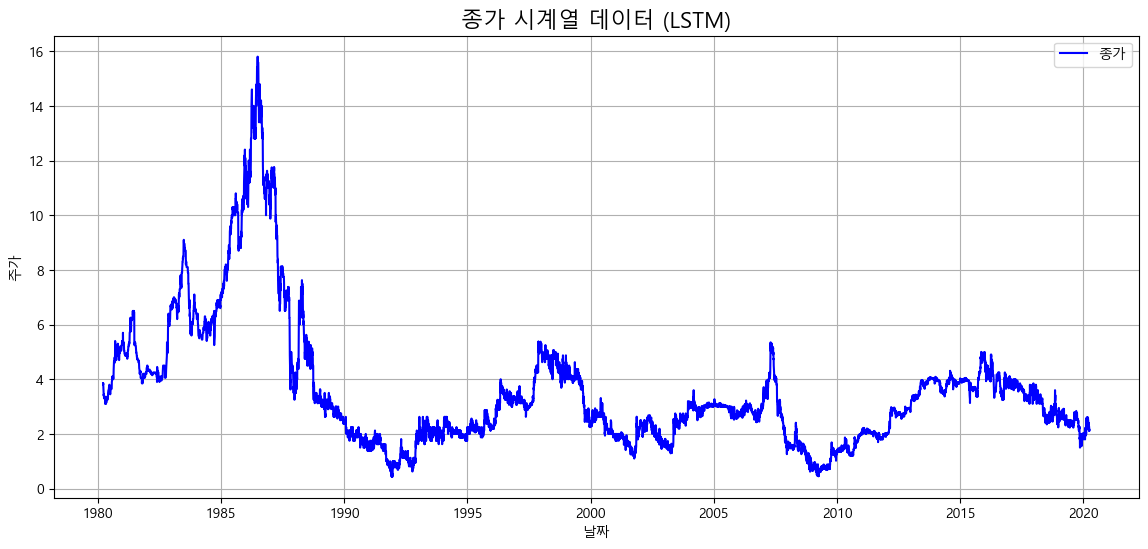

In [3]:
# 2. 시각화
plt.figure(figsize=(14,6))
plt.plot(df.index, df[target_column], label='종가', color='blue')
plt.title('종가 시계열 데이터 (LSTM)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('주가')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# 3. 전처리
data = df[target_column].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_dataset(data, time_step=60):
    X, y, dates = [], [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
        dates.append(df.index[i+time_step])
    return np.array(X), np.array(y), np.array(dates)

time_step = 60
X, y, dates = create_dataset(scaled_data, time_step)

In [5]:
# 4. 데이터 분할
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_dates = dates[train_size:]

X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)

In [6]:
# 5. LSTM 모델 구성
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

C:\Users\leehy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# 6. 모델 학습
print("\nLSTM 모델 학습 중...")
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


LSTM 모델 학습 중...
Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 53s 222ms/step - loss: 0.0125 - val_loss: 2.8302e-04
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - loss: 0.0017 - val_loss: 2.2599e-04
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - loss: 0.0014 - val_loss: 1.5840e-04
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - loss: 0.0013 - val_loss: 1.3227e-04
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 0.0011 - val_loss: 1.4040e-04
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 0.0012 - val_loss: 1.5873e-04
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - loss: 0.0011 - val_loss: 1.9784e-04
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 36s 178ms/step - loss: 9.7353e-04 - val_loss: 1.3831e-04
Epoch 9/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - loss: 9.2553e-04 - val_loss: 1.1538e-04
Epoch 10/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 223ms/step - loss: 9.2237e-04 - val_loss: 2.2933e-04
Epoch 11/100
201/201 ━━━━━━━━━

In [8]:
# 7. 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step


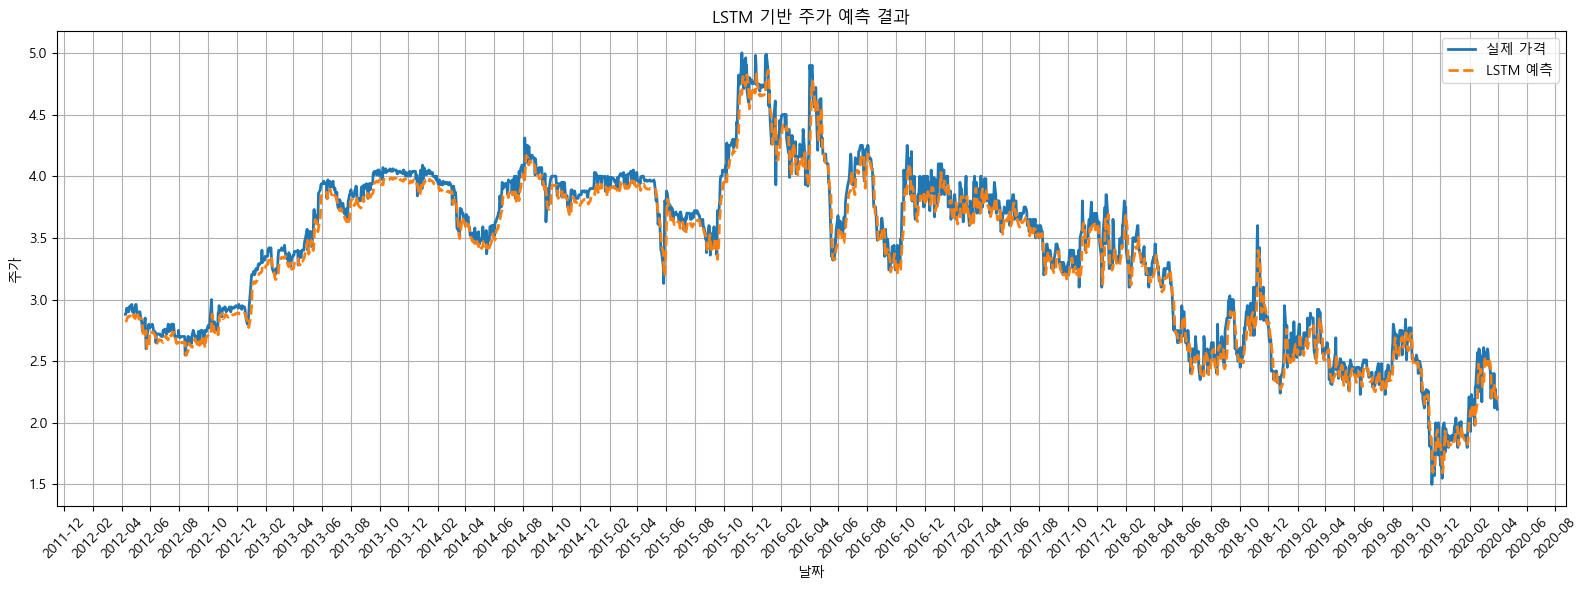

In [9]:
# 8. 결과 시각화
plt.figure(figsize=(16,6))
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.plot(test_dates, y_actual, label='실제 가격', linewidth=2)
plt.plot(test_dates, predictions, '--', label='LSTM 예측', linewidth=2)
plt.title('LSTM 기반 주가 예측 결과')
plt.xlabel('날짜')
plt.ylabel('주가')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

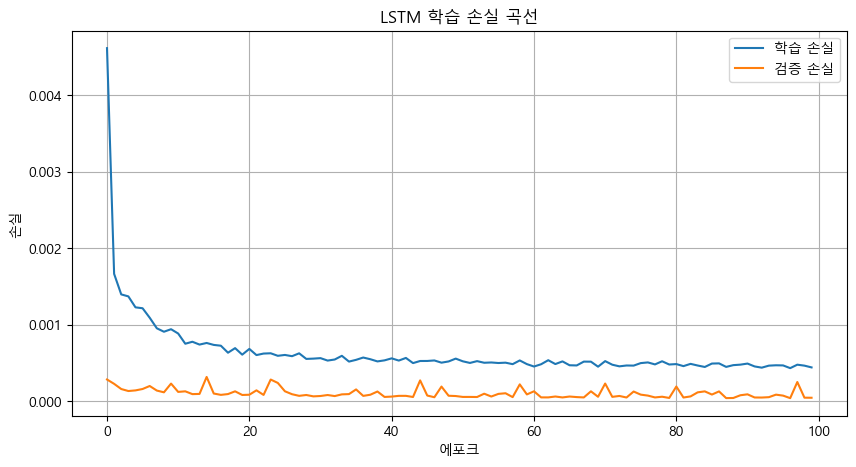

In [10]:
# 9. 손실 시각화
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='학습 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title('LSTM 학습 손실 곡선')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# 10. 예측 값 출력
print("\n최근 5일 예측 성능:")
print("실제값:", y_actual[-5:].flatten().round(2))
print("예측값:", predictions[-5:].flatten().round(2))



최근 5일 예측 성능:
실제값: [2.12 2.28 2.25 2.13 2.11]
예측값: [2.3  2.23 2.21 2.21 2.17]
